# Современные инструменты и библиотеки
### Transformers NLTK Sentence-Transformers



## Collect data

#### Установка и импорт необходимых библиотек

In [1]:
!pip install pymorphy3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 55.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import pymorphy3
import nltk
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

#### Загрузка данных

In [4]:
df = pd.read_csv('/content/movie.csv')
df = df.dropna() # удаляем пустые строки

In [5]:
texts = df['overview']
categories = df['name']

#### Визуализация

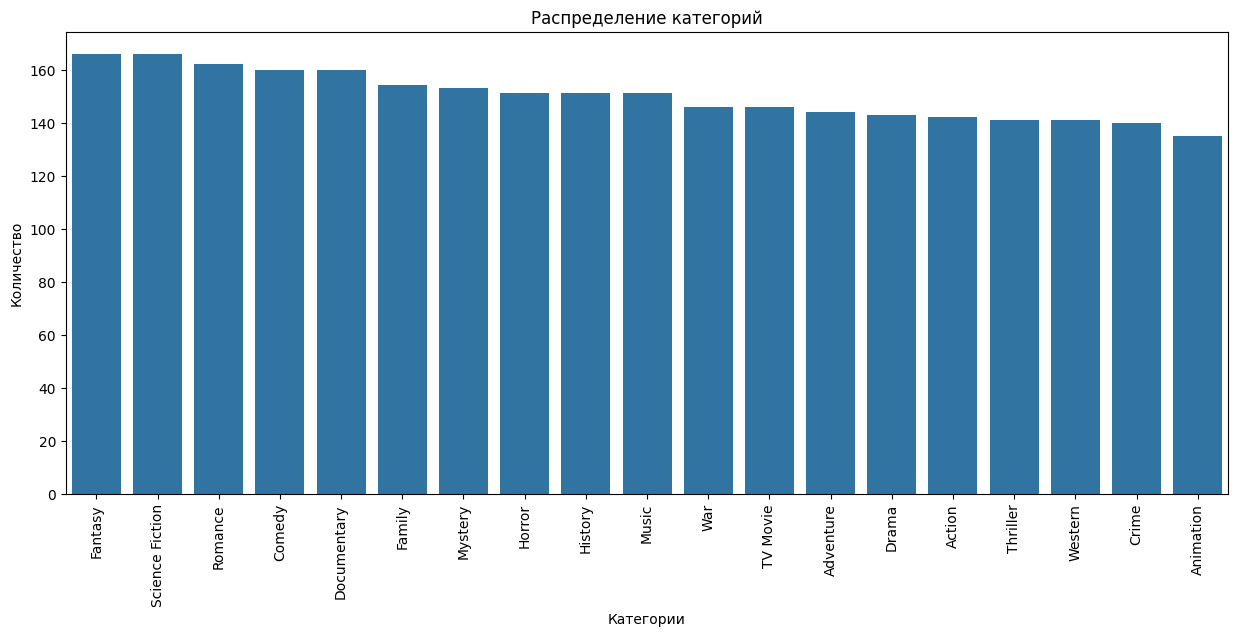

In [6]:
plt.figure(figsize=(15, 6))
sns.countplot(x='name', data=df, order=categories.value_counts().index)
plt.title('Распределение категорий')
plt.xlabel('Категории')
plt.xticks(rotation=90)
plt.ylabel('Количество')
plt.show()

## Prepare data

#### Токенизация и лемматизация

In [7]:
morph = pymorphy3.MorphAnalyzer()

def preprocessing(text):
    # токенизация
    tokens = word_tokenize(text.lower())
    # лемматизация
    lemmatized_tokens = [
        morph.parse(token)[0].normal_form
        for token in tokens if token.isalpha()]

    return ' '.join(lemmatized_tokens)

In [8]:
preprocessed_texts = texts.apply(preprocessing)
print(preprocessed_texts)

0       firemen brothers brian and stephen mccaffrey b...
1       factory worker doug quaid takes a virtual vaca...
2       milan italy santo russo a boy of calabrian ori...
3       zed is an american who travels to paris to mee...
4       a former marine confronts corruption in a smal...
                              ...                        
2995    in the ruins of berlin a boy is left to his ow...
2996    a young man is afraid of asking for sex tips t...
2997    in this feature film based on the hit animated...
2998    an unsuspecting disenchanted man finds himself...
2999    alex an immigrant from ukraine comes to canada...
Name: overview, Length: 2852, dtype: object


#### Векторизация через TFIDF

In [9]:
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(preprocessed_texts)

#### Кластеризация с помощью Spectral Clustering

In [10]:
# Масштабирование данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.toarray())

In [11]:
spectral = SpectralClustering(
    n_clusters=19,
    affinity='nearest_neighbors',
    n_neighbors=10,
    random_state=42
)
labels = spectral.fit_predict(X_scaled)

#### Визуализация

In [12]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

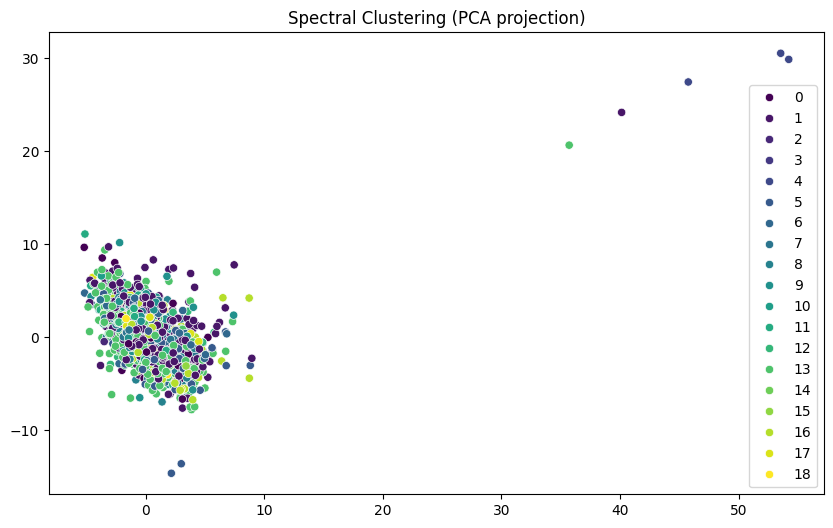

In [13]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=labels,
    palette='viridis',
    legend='full'
)
plt.title('Spectral Clustering (PCA projection)')
plt.show()

### Сравнение результатов с реальной разметкой

In [14]:
if len(set(labels)) > 1:
    score = silhouette_score(X_scaled, labels)
    print(f"Silhouette Score: {score:.3f}")
else:
    print("Все точки в одном кластере!")

# Анализ результатов
df['cluster'] = labels
for cluster in sorted(df['cluster'].unique()):
    print(f"\n Кластер {cluster}:")
    print(df[df['cluster'] == cluster]['name'].value_counts().head(5))

Silhouette Score: -0.086

 Кластер 0:
name
Horror             8
Family             7
Drama              7
Science Fiction    7
Fantasy            6
Name: count, dtype: int64

 Кластер 1:
name
Fantasy            55
Science Fiction    51
Romance            49
Music              45
Mystery            43
Name: count, dtype: int64

 Кластер 2:
name
Thriller           1
History            1
Romance            1
Crime              1
Science Fiction    1
Name: count, dtype: int64

 Кластер 3:
name
Comedy       2
Animation    1
Family       1
Name: count, dtype: int64

 Кластер 4:
name
Romance            1
Science Fiction    1
Western            1
Name: count, dtype: int64

 Кластер 5:
name
Western            14
Horror             12
Music              12
Science Fiction    11
Thriller           11
Name: count, dtype: int64

 Кластер 6:
name
Romance        13
TV Movie       10
Fantasy        10
Documentary     9
Action          8
Name: count, dtype: int64

 Кластер 7:
name
Fantasy      11
Famil

## Разделение на train, test и val выборки

In [15]:
train_data, temp_data = train_test_split(df, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

print(train_data)
print(test_data)
print(val_data)


                                             title  \
1072                              Black Snake Moan   
2084                          The Sum of All Fears   
2825                              The Tigger Movie   
2329                                     Alligator   
1114                                   The Killing   
...                                            ...   
1714                                       Lincoln   
1141                               Despicable Me 3   
1177  Tinker Bell and the Legend of the NeverBeast   
1350                    Barbie and the Secret Door   
895           Friday the 13th Part VI: Jason Lives   

                                               overview      name  cluster  
1072  A God-fearing bluesman takes to a wild young w...    Horror       13  
2084  When the president of Russia suddenly dies, a ...     Music       13  
2825  Winnie the Pooh, Piglet, Owl, Kanga, Roo, and ...   Western        4  
2329  A baby alligator is flushed down a to

## Подбор модели на HuggingFace

#### Установка и импорт необходимых библиотек

In [16]:
!pip install transformers datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.6 MB/s eta 0:00:00


In [17]:
from datasets import Dataset
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score

#### Подготовка данных

In [18]:
# преобразование метки кластеров в числовой формат
label_encoder = LabelEncoder()
train_data['label'] = label_encoder.fit_transform(train_data['cluster'])
val_data['label'] = label_encoder.transform(val_data['cluster'])
test_data['label'] = label_encoder.transform(test_data['cluster'])

In [19]:
# Dataset для HuggingFace
train_dataset = Dataset.from_pandas(train_data[['overview', 'label']])
val_dataset = Dataset.from_pandas(val_data[['overview', 'label']])
test_dataset = Dataset.from_pandas(test_data[['overview', 'label']])

#### Токенизация данных

In [20]:
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples["overview"], truncation=True, padding="max_length")


tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_val = val_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/1996 [00:00<?, ? examples/s]

Map:   0%|          | 0/428 [00:00<?, ? examples/s]

Map:   0%|          | 0/428 [00:00<?, ? examples/s]

#### Метрики предсказания

In [21]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        'accuracy': accuracy_score(labels, predictions),
        'f1': f1_score(labels, predictions, average='weighted')
    }

#### Определение модели и параметров

In [22]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_encoder.classes_))

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    metric_for_best_model="f1",
)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Обучение, валидация во время обучения и тестирование модели

In [23]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics,
)

trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: vktr22stpnv (vktr22stpnv-vvsu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
500,2.203100


TrainOutput(global_step=750, training_loss=2.1398345540364585, metrics={'train_runtime': 359.6542, 'train_samples_per_second': 16.649, 'train_steps_per_second': 2.085, 'total_flos': 793455262765056.0, 'train_loss': 2.1398345540364585, 'epoch': 3.0})

In [24]:
test_results = trainer.evaluate(tokenized_test)
print(f"Test Accuracy: {test_results['eval_accuracy']:.3f}")
print(f"Test F1-score: {test_results['eval_f1']:.3f}")

Test Accuracy: 0.369
Test F1-score: 0.270
